# **IMDB - single CNN averaged**

- In the following script IMDB sentiment reviews is predicted on the basis of averaging prediction of five identicall single layer CNN models
- models are trained on partially independent subsets of oryginal data
- eventually, test dataset is predicted using each of the trained models, and their predictions are averaged (hard simple voting)

**loading modules**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)



import os
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import uuid

os.environ["CUDA_VISIBLE_DEVICES"]="1" 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true" # allows to use the same GPU by more than one process

from tensorflow.keras.preprocessing.text import Tokenizer
from Preprocessor import Preprocessor
from Preprocessor import save_obj as save_obj
from Preprocessor import load_obj as load_obj
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold, train_test_split

from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.models import Sequential

from hyperopt import hp, tpe, Trials, fmin, STATUS_OK, pyll
from shutil import copyfile
from sklearn.metrics import accuracy_score

## Loading and preprocessing data

Data is preprocessedm tokenized and padded<br>
Then five subsets are established

- Remarks:
> - All datasets must be saved for futurre use
> - especially datasets after splitting are unique, and they must be prevented

**loading raw data and cleanning up texts**
- preprocessing operation defined in Preprocessor class (preprocessor.py module)

In [2]:
basedir="..//src_data//"
preproc=Preprocessor()
preproc.load_raw_texts_from_dir(basedir)
preproc.perform_text_cleanup()
preproc.build_datasets()

Datasets loaded
Dataset: train:pos, number of texts: 12500
Dataset: train:neg, number of texts: 12500
Dataset: test:pos, number of texts: 12500
Dataset: test:neg, number of texts: 12500
Texts cleanup finished in 0:00:47.743000
Storing reviews in two dataframes with shapes: train_data: (25000, 2), test_data: (25000, 2)


**Text tokenization and subsets extracted**
- reviews have already been randomized
- selecting 7500 most common tokens, 
- review tokenized and padded with length of 612 tokens
- splitted into five subset, each containing 20000 reviews for training and 5000 for validation, without overlaps

In [3]:
VOCAB_SIZE=7500 # number of most frequent words used
PADDING_SIZE=612
tokenizer=Tokenizer(num_words=VOCAB_SIZE,oov_token='<OOV>')
tokenizer.fit_on_texts(preproc.train_data['Review'])
train_sequences=tokenizer.texts_to_sequences(preproc.train_data['Review'])
test_sequences=tokenizer.texts_to_sequences(preproc.test_data['Review'])
train_labels=preproc.train_data['Sentiment'].values
test_labels=preproc.test_data['Sentiment'].values

train_sequences=pad_sequences(train_sequences, maxlen=PADDING_SIZE, padding='post', truncating='post')
test_sequences=pad_sequences(test_sequences, maxlen=PADDING_SIZE, padding='post', truncating='post')


n_splits=5
kfold=KFold(n_splits=n_splits, random_state=123)
train_datasets={}
for idx,train_indices in enumerate(kfold.split(preproc.train_data)):
    train_datasets[idx]={'train':train_sequences[train_indices[0]],
                         'val':train_sequences[train_indices[1]],
                        'train_labels':preproc.train_data['Sentiment'].values.reshape(25000,1)[train_indices[0]],
                        'val_labels':preproc.train_data['Sentiment'].values.reshape(25000,1)[train_indices[1]]
                        }


**Saving datasets**
- datasets **must** be saved to be reused during predictions averaging

In [4]:
save_obj(train_datasets,'data//averager_train_datasets.pkl')
save_obj(test_sequences,'data//averager_test_sequences.pkl')
save_obj(test_labels,'data//averager_test_labels.pkl')
save_obj(train_sequences,'data//averager_train_sequences.pkl')
save_obj(train_labels,'data//averager_train_labels.pkl')

## Training

**model preparation**
- responsible for creating a model instance according to passed parameters
- some layers are optionall and exists only, if a parameter is non-zero
- dropout layers are created only if associated layer is created. 

In [5]:
def prepare_model(params, model_name='CNN_model'):
    tf.reset_default_graph()
    inputs=tf.keras.Input(shape=(params['PaddingSize'],),)
    stack=tf.keras.layers.Embedding(input_dim=params['VocabSize'], output_dim=params['EmbedDim'], input_length=params['PaddingSize'])(inputs)
    if params['EmbedDrop']>0:
        stack=tf.keras.layers.Dropout(rate=params['EmbedDrop'])(stack)    
    stack=tf.keras.layers.Conv1D(filters=params['CONV_1_units'], 
                                 kernel_size=params['CONV1_kernel_size'], 
                                 activation='elu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l1_l2(
                                     l1=params['CONV1_kernel_rgularizer_L1_ratio'], 
                                     l2=params['CONV1_kernel_rgularizer_L2_ratio']))(stack)
    stack=tf.keras.layers.GlobalMaxPooling1D()(stack)
    if params['MaxPoolDropout']>0:
        stack=tf.keras.layers.Dropout(rate=params['MaxPoolDropout'])(stack)
    stack=tf.keras.layers.Dense(units=params['Dense_1_units'], activation='relu', name='Dense_1')(stack)
    if params['Dense_1_dropout']>0:
        stack=tf.keras.layers.Dropout(rate=params['Dense_1_dropout'])(stack)
    if params['Dense_2_units']>0:
        stack=tf.keras.layers.Dense(units=params['Dense_2_units'], activation='relu', name='Dense_2')(stack)
        if params['Dense_2_dropout']>0:
            stack=tf.keras.layers.Dropout(rate=params['Dense_2_dropout'])(stack)
    if params['Dense_3_units']>0:
        stack=tf.keras.layers.Dense(units=params['Dense_3_units'], activation='relu', name='Dense_3')(stack)
        if params['Dense_3_dropout']>0:
            stack=tf.keras.layers.Dropout(rate=params['Dense_3_dropout'])(stack)
    if params['Dense_4_units']>0:
        stack=tf.keras.layers.Dense(units=params['Dense_4_units'], activation='relu', name='Dense_4')(stack)
    outputs=tf.keras.layers.Dense(units=1, activation='sigmoid')(stack)
    model=tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss='binary_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])
    return model

**model training**
- model training is performed with early stopping callback, based on validation loss value

In [ ]:
def evaluate_dn_model(model, params, train_datasets, 
                      max_no_improvement=5, verbose=2, logdir=None, max_epochs=20):
    """
    @model : tensorflow model to evaluate
    @padded_sequences_dict : a dictionary with padded sentences and labels
    @model_params : params of model
    @max_no_improvement: number of epochs with no improvement on validation loss
    @verbose: 0 - no printout, 1 - more detailed, 2 - epochs oneliner
    @logdir: Tensorboard logging directory. No logging if None, default None
    @max_epochs: maximum number of epochs
    """
    start=dt.datetime.now()
    #generators to feed model
    
    #adding callbacks for early stopping and tensorboard data sending 
    model_callbacks=[
        EarlyStopping(min_delta=1e-4, patience=max_no_improvement, 
                      verbose=verbose, restore_best_weights=True)]
    if logdir:
        model_callbacks.append(TensorBoard(log_dir=logdir+model.name, 
                                           write_graph=True, 
                                           profile_batch=0))
    
    #training model

    history=model.fit(x=train_datasets['train'], 
              y=train_datasets['train_labels'], 
              batch_size=params["batch_size"], epochs=max_epochs, verbose=verbose, callbacks=model_callbacks, 
              validation_data=(train_datasets['val'], train_datasets['val_labels'])
             )

    #evaluating results
    eval_result=model.evaluate(x=train_datasets['val'], y=train_datasets['val_labels'], verbose=verbose )

    #store results
    training_duration=dt.datetime.now()-start
    base_results={
         'Evaluation accuracy':eval_result[1],
         'Evaluation loss':eval_result[0],
         'Duration':training_duration,
         'History':history.history,
         'Trained params':int(np.sum([tf.keras.backend.count_params(p) for p in set(model.trainable_weights)]))}

    return  model, base_results

**model architecture and hyperparameters search**
- Hyperopt was used for searching for model hyperparameters and architecture (f.e numbers of dense layers and existence of dropout layers)
- Hyperparameter search is performed in loops with bayes algorithm for selection the direction of change
- Validation loss is used for evaluation of the results of change
- every time the change is benefitial, the model is saved
- finally the best model is seldected

In [7]:
best_models={}

for k in train_datasets:
    
    last_best_score=0
    results_hopt=pd.DataFrame()
    def objective_minimum_local(params):
        s_=dt.datetime.now()
        scores={}
        model=prepare_model(params,model_name='CNN_model_{}'.format(k))
        model, model_results=evaluate_dn_model(model=model,params=params, train_datasets=train_datasets[k], verbose=0)

        loss = 1-model_results['Evaluation accuracy']

        global results_hopt
        _={x:model_results[x] for x in ['Evaluation accuracy','Evaluation loss','Evaluation loss']}
        _={**params,**_}
        _['Duration']=dt.datetime.now()-s_
        results_hopt=results_hopt.append(pd.DataFrame.from_dict(_,orient='index').T)
        results_hopt.to_excel('reports//results_{}_{}_{}_{}_{}.xlsx'.format(model.name,
                                                                            params['VocabSize'], 
                                                                            params['EmbedDim'],
                                                                            params['CONV1_kernel_size'],
                                                                            os.environ["CUDA_VISIBLE_DEVICES"]))

        global last_best_score
        model_file=''
        if model_results['Evaluation accuracy']>last_best_score:
            model_file="CNN_OPT//{}_{}_{}_{}_{}_{}.hd5".format(model.name,
                                                               params['VocabSize'], 
                                                               params['EmbedDim'],
                                                               params['CONV1_kernel_size'],
                                                               os.environ["CUDA_VISIBLE_DEVICES"],
                                                               str(uuid.uuid4()))
            model.save(model_file)
            last_best_score=model_results['Evaluation accuracy']
        return {"loss":loss, "results":model_results, 'params': params, 'model':model_file, 'status': STATUS_OK, }

    params={
        # data related params
        'PaddingSize': hp.choice('PaddingSize',[PADDING_SIZE]),
        'VocabSize': hp.choice('VocabSize',[VOCAB_SIZE]),
        # model related params
        'EmbedDim':hp.choice('EmbedDim',[100]),
        'EmbedDrop':hp.uniform('EmbedDrop',0.,0.5),
        'CONV_1_units': pyll.scope.int(hp.uniform('CONV_1_units',100,300)),
        'CONV1_kernel_size': hp.choice('CONV1_kernel_size',[3]),
        'CONV1_kernel_rgularizer_L2_ratio': hp.uniform('CONV1_kernel_rgularizer_L2_ratio',1e-6,1e-4),
        'CONV1_kernel_rgularizer_L1_ratio': hp.uniform('CONV1_kernel_rgularizer_L1_ratio',1e-6,1e-4),
        'MaxPoolDropout':hp.uniform('MaxPoolDropout',0.,0.5),
        'Dense_1_units':pyll.scope.int(hp.uniform('Dense_1_units',100,400)),
        'Dense_2_units':pyll.scope.int(hp.uniform('Dense_2_units',100,400)),
        'Dense_3_units':hp.choice('Dense_3_units',[0]),
        'Dense_4_units':hp.choice('Dense_4_units',[0]),
        'Dense_1_dropout':hp.uniform('Dense_1_dropout',0.,0.5),
        'Dense_2_dropout':hp.uniform('Dense_2_dropout',0.,0.5),
        'Dense_3_dropout':hp.uniform('Dense_3_dropout',0.,0.5),
        'batch_size':hp.choice('batch_size',[16,32,64,96,128])
    }

    MAX_EVAL=100

    bayes_trials = Trials()
    best=fmin(fn=objective_minimum_local, space=params, algo=tpe.suggest, max_evals=MAX_EVAL, trials=bayes_trials)
    model_uid=bayes_trials.best_trial['result']['model']
    print('Best model:', model_uid)
    best_models[k]={'model_file':os.path.split(model_uid)[-1], 'model_params':bayes_trials.best_trial['result']['params']}
    copyfile(model_uid, os.path.split(model_uid)[-1])

100%|████████████████████████████████████████████████| 100/100 [46:59<00:00, 28.19s/it, best loss: 0.10000002384185791]
Best model: CNN_OPT//CNN_model_0_7500_100_3_1_a86d728c-4904-4fa6-ad38-a4adcebba39e.hd5
100%|████████████████████████████████████████████████| 100/100 [39:47<00:00, 23.88s/it, best loss: 0.10900002717971802]
Best model: CNN_OPT//CNN_model_1_7500_100_3_1_845f8668-3f9e-4e6b-a5ed-fd6eb0d5e3fb.hd5
100%|████████████████████████████████████████████████| 100/100 [40:02<00:00, 24.03s/it, best loss: 0.10259997844696045]
Best model: CNN_OPT//CNN_model_2_7500_100_3_1_161f62ba-13ef-4942-8555-b1daa0c18a24.hd5
100%|████████████████████████████████████████████████| 100/100 [40:24<00:00, 24.24s/it, best loss: 0.10680001974105835]
Best model: CNN_OPT//CNN_model_3_7500_100_3_1_1f19c601-4a52-42bd-b8f8-93c1d11c1df4.hd5
100%|████████████████████████████████████████████████| 100/100 [38:38<00:00, 23.19s/it, best loss: 0.10420000553131104]
Best model: CNN_OPT//CNN_model_4_7500_100_3_1_12f05a

In [ ]:
save_obj(best_models,'best_models_optimized.pkl')

## Final results

In [4]:
# use this only if the notebook was restarted
best_models=load_obj('best_models_optimized.pkl')

train_datasets=load_obj('data//averager_train_datasets.pkl')
test_sequences=load_obj('data//averager_test_sequences.pkl')
test_labels=load_obj('data//averager_test_labels.pkl')
train_sequences=load_obj('data//averager_train_sequences.pkl')
train_labels=load_obj('data//averager_train_labels.pkl')

**evaluating individual models on test sequences**

In [6]:
models_optimized={}
for k in best_models:
    models_optimized[k]=tf.keras.models.load_model(best_models[k]['model_file'])

for k in models_optimized:
    models_optimized[k].evaluate(x=test_sequences,y=test_labels )
       

25000/25000 [==============================] - 10s 405us/sample - loss: 0.3180 - acc: 0.8897


**averaging models predictions**

In [64]:
preds_test_proba_df=pd.DataFrame(test_labels, columns=['Test_label'])
for k in models_optimized:
    preds_test_proba_df=preds_test_proba_df.join(pd.Series(models_optimized[k].predict(x=test_sequences ).reshape(1,-1)[0], name='Model_{}'.format(k)))


from sklearn.metrics import classification_report
class_reps={}
for col in preds_test_proba_df.columns[1:]:
    class_reps[col]=classification_report(y_true=preds_test_proba_df['Test_label'],
                                          y_pred=preds_test_proba_df[col].apply(
                                              lambda x: 1 if x>=0.5 else 0), digits=4, output_dict=True)
class_reps['Averaged']=classification_report(y_true=preds_test_proba_df['Test_label'],
                                          y_pred=preds_test_proba_df.iloc[:,1:].apply(
                                              lambda r: 1 if np.mean(r)>0.5 else 0,axis=1), 
                                             digits=4, output_dict=True)



results_df=pd.DataFrame.from_dict({x:{'accuracy':class_reps[x]['accuracy'],
                           'precision_0':class_reps[x]['0']['precision'],
                           'precision_1':class_reps[x]['1']['precision']} for x in class_reps}).T
results_df.index.name='Model'

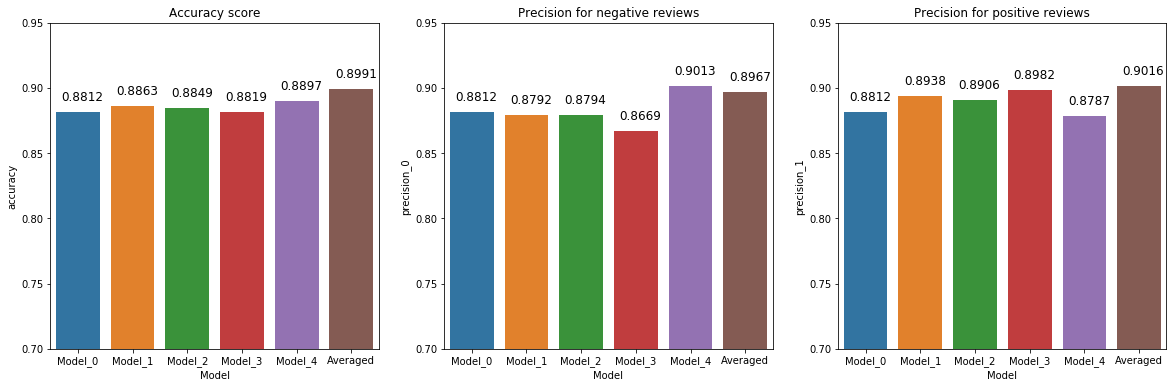

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,3,figsize=(20,6))

for x in [(ax[0],'accuracy','Accuracy score'),
          (ax[1],'precision_0','Precision for negative reviews'),
          (ax[2],'precision_1','Precision for positive reviews')]:
    x[0].set_ylim(0.7,0.95)    
    sns.barplot(data=results_df.reset_index(),y=x[1],x='Model',ax=x[0])
    for p in x[0].patches:
        x[0].text(x=p.get_x()+0.25*p.get_width()/2,y=p.get_y()+p.get_height()*1.01,s='{:.4f}'.format(p.get_height()),fontdict={'fontsize':12})
    x[0].set_title(x[2])



## Summary
- averaging models improved accuracy score  by ~1% in comparison to best model and ~2% in comparison to the worst
- it is worth to mention that improvement is visible for majority of model-metric combination, but not for all of them